# Repeated measurements on Starmon-5 -- Analysis

In [1]:
import time
import json
import copy
import matplotlib
from typing import List
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import itertools as it

import qiskit
import qiskit.tools.jupyter
from qiskit import QuantumCircuit
import qiskit.circuit.library.standard_gates as gates
import qiskit.tools.visualization as qvis # circuit_drawer, plot_histogram

from quantuminspire.credentials import get_token_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

# matplotlib.style.use('ggplot')
# matplotlib.style.use('seaborn')
# %matplotlib notebook
%qiskit_version_table

In [2]:
QI_URL = r'https://api.quantum-inspire.com/'
authentication = get_token_authentication()

qi = QuantumInspireAPI(QI_URL, authentication, project_name="repeated_msmts")
QI.set_authentication(authentication)
starmon5 = QI.get_backend("Starmon-5")
print(qi.get_backend_types()[1]['status'])
starmon5.status()

IDLE


In [15]:
DATA_DIR = "../../data/"


### Utils library

In [7]:
def get_expected_value(operator, state, n):
    m = 1
    for i in range(n):
        if operator[i] == 'Z' and state[i] == '1':
            m *= -1
    return m

def gen_M_matrix(n):
    # List of different Operators
    ops = ['I','Z']
    Operators = [''.join(op) for op in it.product(ops, repeat=n)]
    # List of calibration points
    states = ['0','1']
    Cal_points = [''.join(s) for s in it.product(states, repeat=n)]
    # Calculate M matrix
    M = np.zeros((2**n, 2**n), dtype=int)
    for j, state in enumerate(Cal_points):
        Betas = np.ones(len(Operators))
        for i in range(2**n):
            Betas[i] = get_expected_value(Operators[i], state, n)
        M[j] = Betas
    M = np.linalg.pinv(M) # invert matrix
    return M

def get_Beta_matrix(Cal_shots_dig, n):
    # List of different Operators
    ops = ['I','Z']
    Operators = [''.join(op) for op in it.product(ops, repeat=n)]
    # List of qubits
    Qubits = list(Cal_shots_dig.keys())
    # Calculate Beta matrix
    H = {}
    B = {}
    M = gen_M_matrix(n)
    for op in Operators[1:]:
        H[op] = np.zeros(2**n)
        for i, state in enumerate(Cal_shots_dig[Qubits[0]].keys()):
            correlator = 1
            for j, qubit in enumerate(Qubits):
                if op[j] == 'Z':
                    correlator *= np.array(Cal_shots_dig[Qubits[j]][state])
            H[op][i] = np.mean(correlator)
        B[op] = np.dot(M, H[op])
    return B

def gen_gate_order(n):
    # Gate order in experiment
    tomo_gates = ['Z', 'X', 'Y']
    Gate_order = [''.join(op)[::-1] for op in it.product(tomo_gates, repeat=n)]
    return np.array(Gate_order)

def gen_n_Q_pauli(n):
    # Single qubit pauli terms
    Pauli_operators = {}
    Pauli_operators['I'] = np.array([[  1,  0],
                                     [  0,  1]])
    Pauli_operators['Z'] = np.array([[  1,  0],
                                     [  0, -1]])
    Pauli_operators['X'] = np.array([[  0,  1],
                                     [  1,  0]])
    Pauli_operators['Y'] = np.array([[  0,-1j],
                                     [ 1j,  0]])
    # Four qubit pauli terms
    pauli_ops = ['I', 'X', 'Y', 'Z']
    Pauli_terms = {}
    Operators = [''.join(op) for op in it.product(pauli_ops, repeat=n)]
    for Op in Operators:
        Pauli_terms[Op] = Pauli_operators[Op[0]]
        for op in Op[1:]:
            Pauli_terms[Op] = np.kron(Pauli_terms[Op], Pauli_operators[op])
    return Pauli_terms

def get_Pauli_expectation_values(Beta_matrix, Gate_order, Mask, Tomo_shots_dig):
    '''
    Calculates Pauli expectation values (PEVs) in three steps:
        1. Calculate raw PEVs.
        2. Condition (post-select) data on no errors in stabilizers.
        3. Apply readout corrections to PEVs based on Beta matrix.
    '''
    Qubits = list(Tomo_shots_dig.keys()) #[1:]
    n = len(Qubits)
    # print(Qubits, n)

    B_matrix = np.array([Beta_matrix[key][1:] for key in Beta_matrix.keys()])
    B_0 = np.array([Beta_matrix[key][0] for key in Beta_matrix.keys()])
    iB_matrix = np.linalg.inv(B_matrix)
    pauli_ops = ['I', 'X', 'Y', 'Z']
    P_values = {''.join(op):[] for op in it.product(pauli_ops, repeat=n)}
    P_frac = copy.deepcopy(P_values)
    for i, pre_rotation in enumerate(Gate_order[:]):
        combs = [('I', op) for op in pre_rotation ]
        P_vector = {''.join(o):1 for o in it.product(*combs)}
        for correlator in P_vector.keys():
            # Calculate raw PEVs
            C = 1
            for j, qubit in enumerate(Qubits):
                if correlator[n-j-1] != 'I':
                    # C *= np.array(Tomo_shots_dig[qubit][i], dtype=float)
                    C *= np.array(Tomo_shots_dig[qubit][pre_rotation], dtype=float)
            # Post-select data on stabilizer measurements
            C = C*Mask[i]
            n_total = len(C)
            C = C[~np.isnan(C)]
            n_selec = len(C)
            P_vector[correlator] = np.mean(C)
            P_frac[correlator] = n_selec/n_total
        # Aplly readout corrections
        P = np.array([P_vector[key] for key in list(P_vector.keys())[1:]])
        P_corrected = np.dot(P-B_0, iB_matrix)
        P_vec_corr = { key: P_corrected[i-1] if i!=0 else 1 for i, key in enumerate(list(P_vector.keys()))}
        # Fill main pauli vector with corresponding expectation values
        for key in P_vec_corr.keys():
            P_values[key].append(P_vec_corr[key])
    # Average all repeated pauli terms
    for key in P_values:
        P_values[key] = np.mean(P_values[key])
    # Calculate density matrix
    Pauli_terms_n = gen_n_Q_pauli(n)
    rho = np.zeros((2**n,2**n))*(1+0*1j)
    for op in Pauli_terms_n.keys():
        rho += P_values[op]*Pauli_terms_n[op]/2**n
    return P_values, rho, P_frac

def fidelity(rho_1, rho_2, trace_conserved = False):
    if trace_conserved:
        if np.round(np.trace(rho_1), 3) !=1:
            raise ValueError('rho_1 unphysical, trace =/= 1, but ', np.trace(rho_1))
        if np.round(np.trace(rho_2), 3) !=1:
            raise ValueError('rho_2 unphysical, trace =/= 1, but ', np.trace(rho_2))
    sqrt_rho_1 = sp.linalg.sqrtm(rho_1)
    eig_vals = sp.linalg.eig(np.dot(np.dot(sqrt_rho_1,rho_2),sqrt_rho_1))[0]
    pos_eig = [vals for vals in eig_vals if vals > 0]
    return float(np.sum(np.real(np.sqrt(pos_eig))))**2

In [8]:
from matplotlib.colors import to_rgba

def plot_density_matrix(
        rho,
        ax,
        rho_id=None,
        title='',
        fidelity=None,
        angle=None,
        angle_text='',
        ps_frac=None,
        nr_shots=None,
        **kw,
):
    fig = ax.get_figure()
    n = len(rho)
    # xedges = np.arange(-.75, n, 1)
    # yedges = np.arange(-.75, n, 1)
    xedges = np.linspace(0, 1, n+1)
    yedges = np.linspace(0, 1, n+1)
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    dx = dy = 1/n*0.8
    dz = np.abs(rho).ravel()
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["C3",'darkseagreen',"C0",'antiquewhite',"C3"])
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["firebrick",'forestgreen','snow',"royalblue","firebrick"])
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["firebrick",'darkseagreen','snow',"steelblue","firebrick"])
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black",'blue',"white",'red',"black"])
    norm = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)
    # cmap = matplotlib.cm.get_cmap('seismic')
    # norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=np.pi)
    # color = cmap(norm([np.angle(e) for e in rho.ravel()]))
    color = cmap(norm(np.angle(rho).ravel()))
    # print(list(zip(np.angle(rho).ravel(), norm(np.angle(rho).ravel()))))
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max',
             color=color, alpha=0.8, edgecolor='black', linewidth=.1)

    if rho_id is not None:
        # color_id = cmap(norm([np.angle(e) for e in rho_id.ravel()]))
        color_id = cmap(norm(np.angle(rho_id).ravel()))
        dz1 = np.abs(rho_id).ravel()
        # selector
        s = [k for k in range(len(dz1)) if dz1[k] > .15]
        colors = [ to_rgba(color_id[k], 0.3) if dz1[k] >= dz[k] else to_rgba(color_id[k], 1) for k in s ]
        Z = [ dz[k] if dz1[k] >= dz[k] else dz1[k] for k in s ]
        DZ = [ dz1[k]-dz[k] if dz1[k] >= dz[k] else dz[k]-dz1[k] for k in s ]
        ax.bar3d(xpos[s], ypos[s], Z, dx, dy, dz=DZ, zsort='min',
                 color=colors, edgecolor=to_rgba('black', .25), linewidth=0.5)

    N = int(np.log2(n))
    states = ['0', '1']
    combs = [''.join(s) for s in it.product(states, repeat=N)]
    tick_period = n//(3-2*(N%2)) - N%2
    ax.set_xticks(xpos[::n][::tick_period]+1/n/2)
    ax.set_yticks(ypos[:n:tick_period]+1/n/2)
    ax.set_xticklabels(combs[::tick_period], rotation=20, fontsize=6, ha='right')
    ax.set_yticklabels(combs[::tick_period], rotation=-40, fontsize=6)
    ax.tick_params(axis='x', which='major', pad=-6, labelsize=6)
    ax.tick_params(axis='y', which='major', pad=-6, labelsize=6)
    ax.tick_params(axis='z', which='major', pad=-2, labelsize=6)
    for tick in ax.yaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")

    if (rho > 0.7).any() or (rho_id > 0.6).any():
        ax.set_zticks(np.linspace(0, 1, 9))
        ax.set_zticklabels(['0', '', '0.25', '', '0.5', '', '0.75', '', '1.0'])
        ax.set_zlim(0, 1.0)
    else:
        ax.set_zticks(np.linspace(0, 0.5, 5))
        ax.set_zticklabels(['0', '', '0.25', '', '0.5'])
        ax.set_zlim(0, 0.5)

    ax.set_zlabel(r'$|\rho|$', labelpad=-8, size=7, rotation=45)
    ax.set_title(title, size=7)
    # Text box
    s = r'$F_{|\psi\rangle}='+fr'{fidelity*100:.1f}\%$'
    s += '\n' + angle_text if angle_text else '\n' + r'$\mathrm{arg}(\rho_{0,15})='+fr'{angle:.1f}^\circ$' if angle else ''
    s += '\n' + r'$P_\mathrm{ps}='+fr'{ps_frac*100:.1f}\%$' if ps_frac else ''

    # s = ''.join((r'$F_{|\psi\rangle}='+fr'{fidelity*100:.1f}\%$', '\n',
    #              angle_text))
                 # r'$\mathrm{arg}(\rho_{0,15})='+fr'{angle:.1f}^\circ$'))
                 # '\n',
                 # r'$P_\mathrm{ps}='+fr'{ps_frac*100:.1f}\%$', '\n',
                 # f'# shots per Pauli {nr_shots}'))
    props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.5)
    ax.text(1, 0.4, 0.7, s, size=5, bbox=props, va='bottom')
    # ax.text(0, 0, 1, s, size=5, bbox=props, va='bottom')
    # colorbar
    # fig.subplots_adjust(bottom=0.1)
    # cbar_ax = fig.add_axes([0.55, 0.56, 0.01, 0.275])
    # cbar_ax = fig.add_axes([0.55, 0.3, 0.01, 0.4])
    cbar_ax = fig.add_axes([0.675, 0.369, 0.015, 0.25])
    # cbar_ax = fig.add_subplot(133)
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["C3",'darkseagreen',"C0",'antiquewhite',"C3"])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cb = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,
                                          orientation='vertical')
    # cb = plt.colorbar(sm, ax=ax, orientation='vertical')
    cb.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cb.set_ticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
    cb.set_label(r'arg$(\rho)$', fontsize=7, labelpad=-10)
    cb.ax.tick_params(labelsize=7)


## Data loading

In [16]:
def get_json_data(file: str, directory: str=DATA_DIR, comment: str='#'):
    with open(directory + file, 'r') as f:
        data_str = [line for line in f.read().split('\n') if line[0] != comment]
        data_dict = json.loads(data_str[0])
    return data_dict

In [17]:
def get_csv_data(file: str, directory: str=DATA_DIR, comment: str='#', single_qubit: bool=False):
    data_hex = np.loadtxt(directory + file, comments=comment, dtype='<U3', delimiter=',')
    # create binary strings of length 5
    data_bin = np.array(list(map(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex.flatten()))).reshape(data_hex.shape)

    # data_bin = np.array(["{0:05b}".format(b) for b in list(map(lambda d: int(d, 16), data_hex.flatten()))]).reshape(data_hex.shape)
    # data_bin = np.frombuffer(data_hex)
    # data_bin = data_hex.astype(np.int16)
    # data_bin = np.array(list(map(lambda x: bin(int(str(x), 16)), data_hex)))
    # measured = np.log2(data_bin) #if data_bin > 0 else 0
    # data_bin = data_bin > 0

    if single_qubit:
        # if only one qubit is measured, just create integer 0s/1s
        # this will disregard any specific qubits in the 1-state and just return 1 if any one qubit was in 1-state
        # the lambda function produces a decimal representation of the binary (hex) string
        data_bin = np.array(list(map(lambda d: int(d, 16), data_hex.flatten()))).reshape(data_hex.shape)
        data_bin = (data_bin > 0).astype(int)

    return data_bin

In [18]:
a = get_csv_data('qubit_0_QND_RAW.csv')
# a = np.expand_dims(a, (0,1))
a

array([['00000', '00001', '00001', ..., '00000', '00000', '00000'],
       ['00000', '00001', '00001', ..., '00000', '00000', '00000'],
       ['00001', '00000', '00001', ..., '00001', '00001', '00001']],
      dtype='<U5')

In [12]:
a[0].sum()

7693

In [13]:
a[0] == 0

array([ True, False, False, ...,  True,  True,  True])

In [16]:
np.where(np.logical_and(a[0]==0, a[1]==0)) #.sum()

(array([    0,     4,     5, ..., 16381, 16382, 16383]),)

In [18]:
np.logical_and(a[0]==0, a[1]==0).sum()

8481

In [17]:
np.where(np.logical_and(a[0]==1, a[1]==1)) #.sum()

(array([    1,     2,     3, ..., 16369, 16374, 16380]),)

In [19]:
np.logical_and(a[0]==1, a[1]==1).sum()

6586

In [43]:
type(bin(int(get_csv_data('qubit_4_QND_RAW.csv')[0][1], 16)))


TypeError: int() can't convert non-string with explicit base

In [21]:
a = 0x4.to_bytes(1,'big')
a

b'\x04'

## Measurement train analysis

In [14]:
def plot_probs(dict_list: List[dict], title: str='', filename: str='default.png', show_plots: bool=False, *args, **kwargs):
    fig, ax = plt.subplots(figsize=(6,5), dpi=90)
    outcomes = set(k for d in dict_list for k in d.keys())
    assert len(outcomes) == 2
    outcome_probs = np.array([list(msmt.values()) for msmt in dict_list]).T

    ax.plot(outcome_probs[0], color='C0', marker='o', linestyle='--', alpha=0.6, markersize=10, markeredgewidth=2)
    ax.plot(outcome_probs[1], color='C1', marker='s', linestyle='--', alpha=0.6, markersize=10, markeredgewidth=2)

    # for i, msmt in enumerate(trans):
    #     ax.plen_gate_order(2)ot(msmt, marker='o', linestyle='--', alpha=0.6)

    ax.set_ylabel("Probability")
    ax.set_xlabel("Measurement iteration")
    ax.set_title(title)
    ax.set_xticks(np.arange(0, len(dict_list)))
    # ax.set_xticklabels(N_ops.keys())
    ax.legend(outcomes, loc=0)
    ax.grid(True, alpha=0.2)
    fig.tight_layout()
    plt.show() if show_plots else plt.close()
    fig.savefig(filename, format='png', dpi=90)

In [15]:
for qb in range(5):
    for N in [2,4,10]:
        exp_name = f"qubit_{qb}_msmts_{N}"
        results = get_json_data(exp_name + "_PROB.json")
        plot_probs(results,
                   title=f"{N} measurements on qubit {qb}",
                   filename=DATA_DIR + exp_name + '_PLOT' + '.png')

        # qvis.plot_histogram(results,
        #                title=exp_name,
        #                filename="./data/" + exp_name + '_HIST' + '.png',
        #                legend=[f"msmt {i}" for i in range(N)],
        #                figsize=(14,8))

In [20]:
exp_name = f"qubit_{0}_msmts_{2}"
with open(DATA_DIR + exp_name + '_PROB' + '.json', 'r') as f:
    # while '#' == f.readline()[0]:
    #     pass
    data = [line for line in f.read().split('\n') if line[0] != '#']
    results = json.loads(data[0])
pprint(results)
fig = qvis.plot_histogram(results)
# fig.axes[0].legend(['msmt 1', 'msmt 2'])
# fig.show()
# type(results[0])


[{'00000': 0.03204345703125, '00001': 0.96795654296875},
 {'00000': 0.2320556640625, '00001': 0.7679443359375}]


array([[0.03204346, 0.23205566],
       [0.96795654, 0.76794434]])


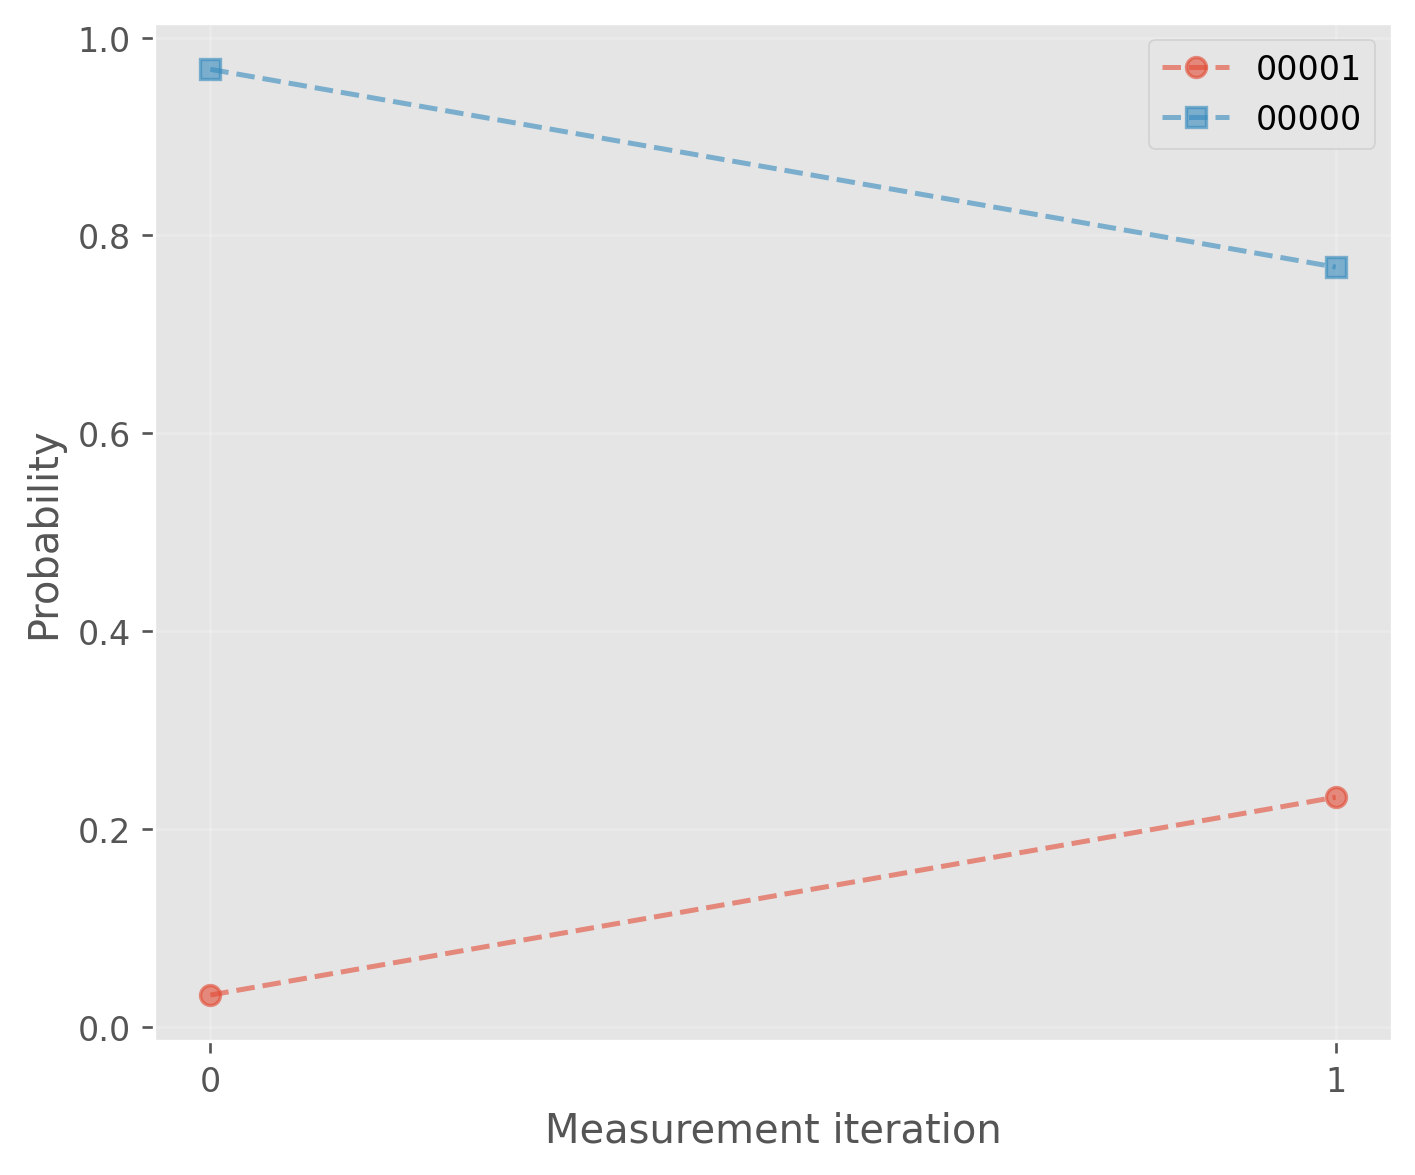

In [63]:
gap = 4
fig, ax = plt.subplots(figsize=(6,5), dpi=120)
outcomes = set(k for d in results for k in d.keys())

outcomes = set(k for d in results for k in d.keys())
assert len(outcomes) == 2
outcome_probs = np.array([list(msmt.values()) for msmt in results]).T
pprint(outcome_probs)

ax.plot(outcome_probs[0], color='C0', marker='o', linestyle='--', alpha=0.6)
ax.plot(outcome_probs[1], color='C1', marker='s', linestyle='--', alpha=0.6)

# for msmt in results:
#     ax.plot(msmt.values(), 'o')

    # ax.bar(msmt.keys(), msmt.values(), alpha=0.6)
    # for k,v in results.items():
    #     print(k,v)
    #     # for i,(g,n) in enumerate(v.items()):
    #     #     print(i,g,n)
    #     ax.bar(k*gap, v, color='C0', alpha=0.6, label="0")
    #     ax.bar(0.8+k*gap, v, color='C1', alpha=0.6, label="1")
    #     ax.bar(1.6+k*gap, v, color='C2', alpha=0.6, label="0.5")

ax.set_ylabel("Probability")
ax.set_xlabel("Measurement iteration")
ax.set_title("")
ax.set_xticks(np.arange(0, len(results)))
# ax.set_xticklabels(N_ops.keys())
ax.legend(outcomes, loc=0)
ax.grid(True, alpha=0.2)
fig.tight_layout()
# fig.savefig("Locations_per_seed_after_gate.png", format='png')
# plt.show()

## QND analysis

In [5]:
def compute_QNDness(data, show: bool=True):
    # P[0(m2) | 0(m1)]
    p1 = np.logical_and(data[1] == 0, data[0] == 0).sum() / (data[0] == 0).sum()
    if show: print(f"P[0(m2) | 0(m1)] = {100*p1:.2f} %")
    # print(np.sum((data[1] == 0) == (data[0] == 0)) / len(data[0]))
    # print(np.sum(np.bitwise_xor(data[0], data[1]) > 0) / len(data[0]))

    # P[1(m2) | 1(m1)]
    p2 = np.logical_and(data[1] == 1, data[0] == 1).sum() / (data[0] == 1).sum()
    if show: print(f"P[1(m2) | 1(m1)] = {100*p2:.2f} %")

    # P[1(m3) | 0(m2)]
    p3 = np.logical_and(data[2] == 1, data[1] == 0).sum() / (data[1] == 0).sum()
    if show: print(f"P[1(m3) | 0(m2)] = {100*p3:.2f} %")
    # if show: print(np.sum((data[2] == 1) == (data[1] == 0)) / len(data[0]))

    # P[0(m3) | 1(m2)]
    p4 = np.logical_and(data[2] == 0, data[1] == 1).sum() / (data[1] == 1).sum()
    if show: print(f"P[0(m3) | 1(m2)] = {100*p4:.2f} %")
    # if show: print(np.sum((data[2] == 0) == (data[1] == 1)) / len(data[0]))

    # P[QND]
    pQND = (p1+p2)/2
    if show: print(f"P[QND] = {100*pQND:.2f} %")

    # P[QND,X]
    pQNDX = (p3+p4)/2
    if show: print(f"P[QND,X] = {100*pQNDX:.2f} %")

    # return p1, p2, p3, p4, pQND, pQNDX

    return pd.Series(data=[p1, p2, p3, p4, pQND, pQNDX], index=["P[0(m2) | 0(m1)]", "P[1(m2) | 1(m1)]", "P[1(m3) | 0(m2)]", "P[0(m3) | 1(m2)]", "P[QND]", "P[QND,X]"])

    # pd.DataFrame(index=[f"qubit {n}" for n in range(5)], columns=["P[0(m2) | 0(m1)]", "P[1(m2) | 1(m1)]", "P[1(m3) | 0(m2)]", "P[0(m3) | 1(m2)]", "P[QND]", "P[QND,X]"])
    # pd.Series

In [10]:
results_df = pd.DataFrame(index=[f"qubit {n}" for n in range(5)],
                          columns=["P[0(m2) | 0(m1)]", "P[1(m2) | 1(m1)]", "P[1(m3) | 0(m2)]", "P[0(m3) | 1(m2)]", "P[QND]", "P[QND,X]"])

for qb in range(5):
    data = get_csv_data(f"qubit_{qb}_QND_RAW.csv")
    print(f"Qubit {qb}")
    if np.any(data > 2):
        print(f"msmt result has 2 for qubit {qb}!")
    probs = compute_QNDness(data, show=False)
    # results_df.columns = probs.index
    results_df.iloc[qb] = probs

results_df = results_df * 100
results_df = results_df.astype(float).round(2)
results_df.to_clipboard(excel=True, sep='\t\t')
results_df
# results_df.to_markdown()

Qubit 0
Qubit 1
Qubit 2
Qubit 3
Qubit 4


/home/redwombat/miniconda3/envs/qi-py38/lib/python3.8/site-packages/pandas/io/clipboards.py:133: UserWarning: to_clipboard in excel mode requires a single character separator.
  warnings.warn(


,P[0(m2) | 0(m1)],P[1(m2) | 1(m1)],P[1(m3) | 0(m2)],P[0(m3) | 1(m2)],P[QND],"P[QND,X]"
qubit 0,97.58,85.61,96.13,72.28,91.60,84.20
qubit 1,92.06,63.44,88.48,68.58,77.75,78.53
qubit 2,91.66,64.48,88.67,67.66,78.07,78.16
qubit 3,97.83,85.55,95.67,87.51,91.69,91.59
qubit 4,95.30,79.96,93.40,78.46,87.63,85.93


In [57]:
for qb in range(5):
    data = get_csv_data(f"qubit_{qb}_QND_v2_RAW.csv")
    print(f"Qubit {qb}")
    if np.any(data > 2):
        print(f"msmt result has 2 for qubit {qb}!")
    compute_QNDness(data, show=True)


Qubit 0
P[0(m2) | 0(m1)] = 49.73 %
P[1(m2) | 1(m1)] = 41.22 %
P[1(m3) | 0(m2)] = 53.84 %
P[0(m3) | 1(m2)] = 21.34 %
P[QND] = 45.48 %
P[QND,X] = 37.59 %
Qubit 1
P[0(m2) | 0(m1)] = 52.40 %
P[1(m2) | 1(m1)] = 39.02 %
P[1(m3) | 0(m2)] = 58.17 %
P[0(m3) | 1(m2)] = 33.64 %
P[QND] = 45.71 %
P[QND,X] = 45.90 %
Qubit 2
P[0(m2) | 0(m1)] = 52.42 %
P[1(m2) | 1(m1)] = 39.62 %
P[1(m3) | 0(m2)] = 56.46 %
P[0(m3) | 1(m2)] = 33.43 %
P[QND] = 46.02 %
P[QND,X] = 44.95 %
Qubit 3
P[0(m2) | 0(m1)] = 52.25 %
P[1(m2) | 1(m1)] = 38.89 %
P[1(m3) | 0(m2)] = 58.06 %
P[0(m3) | 1(m2)] = 32.92 %
P[QND] = 45.57 %
P[QND,X] = 45.49 %
Qubit 4
P[0(m2) | 0(m1)] = 53.19 %
P[1(m2) | 1(m1)] = 38.50 %
P[1(m3) | 0(m2)] = 57.48 %
P[0(m3) | 1(m2)] = 32.60 %
P[QND] = 45.85 %
P[QND,X] = 45.04 %


In [92]:
out = pd.DataFrame(index=[f"qubit {n}" for n in range(5)]) #, columns=["P[0(m2) | 0(m1)]", "P[1(m2) | 1(m1)]", "P[1(m3) | 0(m2)]", "P[1(m3) | 1(m1)]", "P[QND]", "P[QND,X]"])
out.iloc[0] = pd.Series(data=np.zeros(6), index=[i for i in range(6)])
out

ValueError: Must have equal len keys and value when setting with an iterable

In [64]:
data = get_csv_data(f"qubit_{1}_QND_RAW.csv")
# P[0(m2) | 0(m1)
data[1][1]
print(np.bitwise_xor(data[0], data[1]))


0

In [72]:
np.array([1,2,3]) == np.array([0,2,3])


array([False,  True,  True])

## msmt induced dephasing analysis

### Readout error correction

In [8]:
def extract_readout_correction(qubit, filename: str="readout_correction_qb_{}"):
    # data_0 = get_json_data(filename.format(qubit) + "_state0" + "_PROB.json")
    # data_1 = get_json_data(filename.format(qubit) + "_state1" + "_PROB.json")
    # print([list(data_0[0].values())[0] - list(data_0[0].values())[1], list(data_1[0].values())[0] - list(data_1[0].values())[1]] )

    data_0 = get_csv_data(filename.format(qubit) + "_state0" + "_RAW.csv", single_qubit=True)
    data_1 = get_csv_data(filename.format(qubit) + "_state1" + "_RAW.csv", single_qubit=True)
    # print(data_0, data_1)

    # convert 0/1 into +1/-1 operator expectation values
    msmt_0 = 1 - 2*data_0
    msmt_1 = 1 - 2*data_1

    m_avg = np.array([msmt_0.mean(), msmt_1.mean()])
    print("measured Z exp val: ", m_avg)
    beta = 0.5 * np.dot(np.array([[1,1], [1,-1]]), m_avg)
    print("beta vector: ", beta)

    # m_corr = beta[0] + beta[1] * msmt_1.mean()
    # print("corrected averages: ", m_corr)
    Z_corr = (m_avg - beta[0])/beta[1]
    print("corrected Z exp val: ", Z_corr)

    return beta

In [9]:
beta_qb2 = extract_readout_correction(2)
print(beta_qb2)

measured Z exp val:  [ 0.96557617 -0.93164062]
beta vector:  [0.01696777 0.9486084 ]
corrected Z exp val:  [ 1. -1.]
[0.01696777 0.9486084 ]


In [10]:
beta_qb3 = extract_readout_correction(3)
print(beta_qb3)

measured Z exp val:  [ 0.98828125 -0.92285156]
beta vector:  [0.03271484 0.95556641]
corrected Z exp val:  [ 1. -1.]
[0.03271484 0.95556641]


### Tomography analysis

In [54]:
def analyze_msmt_induced_dephasing_tomography(filename: str, readout_correction: List[float]):
    tomo_data = dict.fromkeys(['_MX', '_MY', '_MZ'], None)
    expvals_raw = dict.fromkeys(['_MX', '_MY', '_MZ'])
    expvals_corr = dict.fromkeys(['_MX', '_MY', '_MZ'])

    for m in tomo_data.keys():
        data = get_csv_data(filename + m + "_RAW.csv", single_qubit=True)
        # print(filename, data)
        # convert 0/1 into +1/-1 operator expectation values
        if len(data.shape) > 1:
            # use only last msmt to discard data of inducing qubit
            # (if multiple msmts happen in sequence, each gets its own row in raw data matrix)
            tomo_data[m] = 1 - 2*data[-1]
        else:
            tomo_data[m] = 1 - 2*data
        expvals_raw[m] = tomo_data[m].mean()
        expvals_corr[m] = (expvals_raw[m] - readout_correction[0]) / readout_correction[1]

    print(tomo_data)
    print(expvals_raw)
    print(expvals_corr)

    rho = 0.5 * (gates.IGate().to_matrix()
                 + expvals_corr['_MX'] * gates.XGate().to_matrix()
                 + expvals_corr['_MY'] * gates.YGate().to_matrix()
                 + expvals_corr['_MZ'] * gates.ZGate().to_matrix()
                 )
    pprint(rho)
    qvis.plot_state_city(rho,
                         filename=DATA_DIR + filename + '_PLOT.png',
                         title=filename,
                         alpha=0.6)
    return expvals_corr, rho

In [270]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(1, 2)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb2)

{'_MX': array([ 1,  1,  1, ...,  1, -1,  1]), '_MY': array([-1,  1, -1, ..., -1, -1,  1]), '_MZ': array([-1, -1, -1, ...,  1, -1, -1])}
{'_MX': 0.2366943359375, '_MY': -0.236083984375, '_MZ': -0.8145751953125}
{'_MX': 0.23163042079526444, '_MY': -0.2667610346158796, '_MZ': -0.8765924591429675}
array([[0.06170377+0.j        , 0.11581521+0.13338052j],
       [0.11581521-0.13338052j, 0.93829623+0.j        ]])


In [58]:
print(rho.trace())

(1+0j)


In [32]:
qiskit.quantum_info.DensityMatrix(rho).to_statevector()

QiskitError: 'Density matrix is not a pure state'

In [141]:
np.linalg.eig(rho)

(array([ 1.41660482-4.62809907e-17j, -0.41660482+4.62809907e-17j]),
 array([[ 0.88096001+0.j        ,  0.33459637-0.33459637j],
        [-0.33459637-0.33459637j,  0.88096001+0.j        ]]))

In [56]:
np.rad2deg(np.angle(rho))

array([[  0.        ,  49.03199564],
       [-49.03199564,   0.        ]])

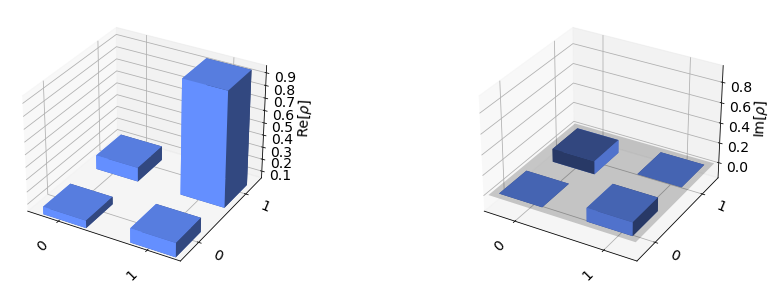

In [13]:
qvis.plot_state_city(rho) #, filename=DATA_DIR + exp_name + '_PLOT.png')

0.9382962343452912 49.03199564221784 0.0
[(0.0, 0.5), (0.8557697627802128, 0.6361999878950495), (-0.8557697627802128, 0.36380001210495044), (0.0, 0.5)]


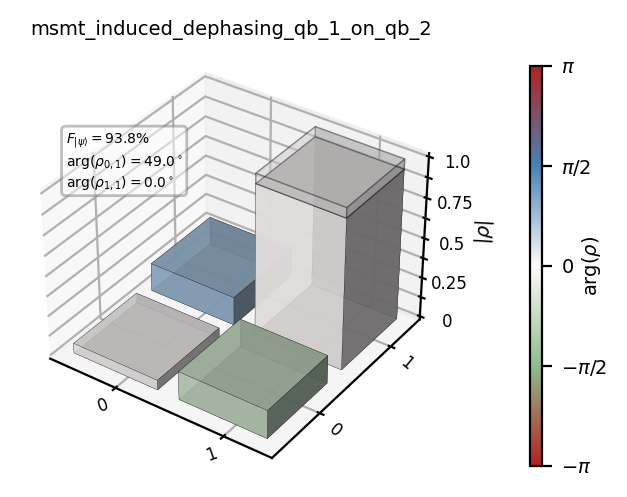

In [271]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, title=exp_name, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

In [272]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(None, 2)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb2)

{'_MX': array([ 1, -1, -1, ..., -1,  1, -1]), '_MY': array([ 1,  1, -1, ..., -1, -1,  1]), '_MZ': array([-1, -1, -1, ..., -1, -1, -1])}
{'_MX': 0.0640869140625, '_MY': -0.240478515625, '_MZ': -0.8460693359375}
{'_MX': 0.04967185690387337, '_MY': -0.2713936430317848, '_MZ': -0.9097928194569553}
array([[0.04510359+0.j        , 0.02483593+0.13569682j],
       [0.02483593-0.13569682j, 0.95489641+0.j        ]])


0.9548964148814266 79.62822761672327 0.0
[(0.0, 0.5), (1.3897747494392982, 0.7211895211575646), (-1.3897747494392982, 0.27881047884243537), (0.0, 0.5)]


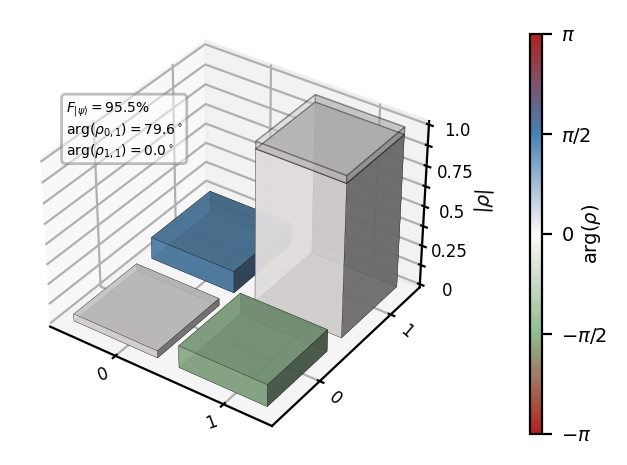

In [273]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
# fig.subplots_adjust(left = 0.0125, right = 0.99, bottom = 0.01, top = 0.99, wspace = 0.01, hspace = 0.01)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

In [274]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(3, 2)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb2)

{'_MX': array([-1, -1,  1, ...,  1, -1, -1]), '_MY': array([ 1, -1, -1, ..., -1,  1,  1]), '_MZ': array([-1, -1, -1, ..., -1, -1, -1])}
{'_MX': 0.3140869140625, '_MY': -0.2181396484375, '_MZ': -0.76318359375}
{'_MX': 0.31321580234204094, '_MY': -0.24784455025093297, '_MZ': -0.8224166773902972}
array([[0.08879166+0.j        , 0.1566079 +0.12392228j],
       [0.1566079 -0.12392228j, 0.91120834+0.j        ]])


0.9112083386951485 38.35421828532718 0.0
[(0.0, 0.5), (0.6694073911075732, 0.6065394952370199), (-0.6694073911075732, 0.39346050476298006), (0.0, 0.5)]


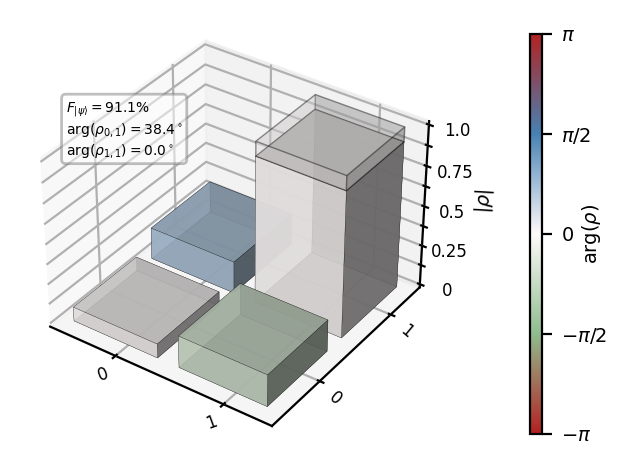

In [275]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

In [276]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(4, 2)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb2)

{'_MX': array([ 1, -1,  1, ...,  1,  1,  1]), '_MY': array([ 1,  1, -1, ..., -1,  1, -1]), '_MZ': array([-1, -1, -1, ...,  1, -1, -1])}
{'_MX': 0.1995849609375, '_MY': -0.22412109375, '_MZ': -0.7835693359375}
{'_MX': 0.19251061639428646, '_MY': -0.2541500450392485, '_MZ': -0.8439068330974134}
array([[0.07804658+0.j        , 0.09625531+0.12707502j],
       [0.09625531-0.12707502j, 0.92195342+0.j        ]])


0.9219534200812073 52.857223323484135 0.0
[(0.0, 0.5), (0.9225325804567379, 0.6468256203430115), (-0.9225325804567379, 0.3531743796569885), (0.0, 0.5)]


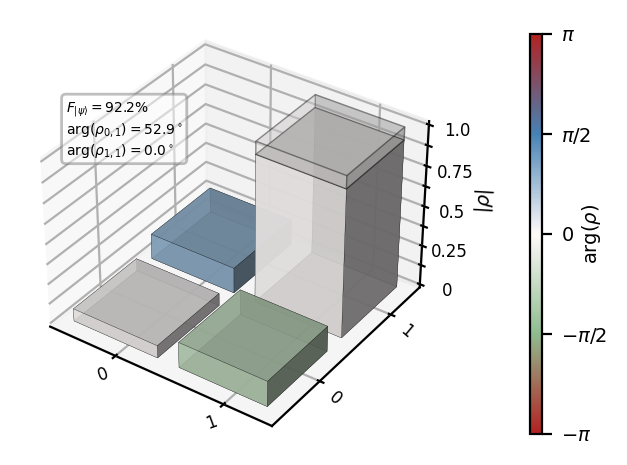

In [278]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

In [279]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(0, 2)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb2)

{'_MX': array([ 1, -1, -1, ..., -1,  1, -1]), '_MY': array([ 1, -1, -1, ..., -1, -1,  1]), '_MZ': array([-1, -1, -1, ..., -1, -1, -1])}
{'_MX': 0.39208984375, '_MY': -0.22412109375, '_MZ': -0.77197265625}
{'_MX': 0.3954446017243598, '_MY': -0.2541500450392485, '_MZ': -0.8316818942221078}
array([[0.08415905+0.j        , 0.1977223 +0.12707502j],
       [0.1977223 -0.12707502j, 0.91584095+0.j        ]])


0.915840947111054 32.72862939307049 0.0
[(0.0, 0.5), (0.5712223425740734, 0.5909128594251959), (-0.5712223425740734, 0.40908714057480416), (0.0, 0.5)]


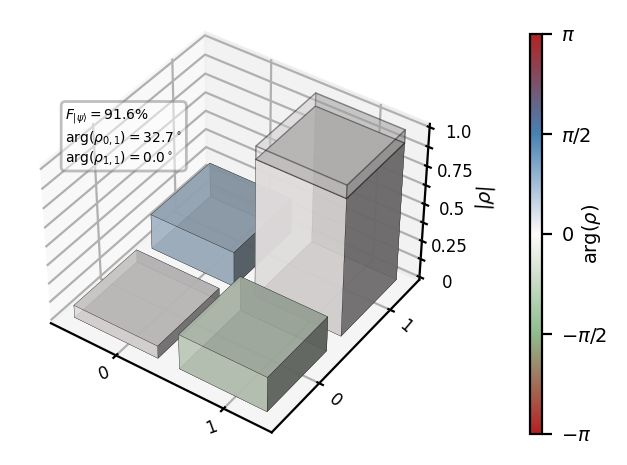

In [280]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=40)
plot_density_matrix(rho, ax, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

In [281]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(2, 3)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb3)

{'_MX': array([ 1,  1,  1, ...,  1, -1, -1]), '_MY': array([ 1,  1,  1, ...,  1, -1,  1]), '_MZ': array([-1,  1, -1, ..., -1, -1,  1])}
{'_MX': 0.20458984375, '_MY': -0.2108154296875, '_MZ': -0.7828369140625}
{'_MX': 0.17986714358712313, '_MY': -0.25485436893203883, '_MZ': -0.8534747061829331}
array([[0.07326265+0.j        , 0.08993357+0.12742718j],
       [0.08993357-0.12742718j, 0.92673735+0.j        ]])


0.9267373544087557 54.78691753381628 0.0
[(0.0, 0.5), (0.9562120979837059, 0.6521858820383785), (-0.9562120979837059, 0.3478141179616214), (0.0, 0.5)]


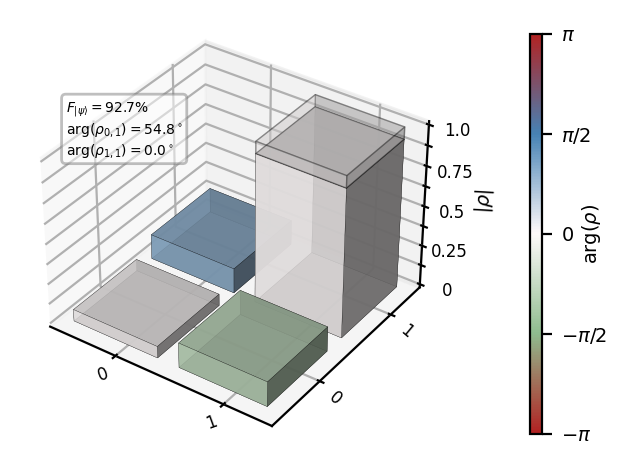

In [283]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

In [284]:
exp_name = "msmt_induced_dephasing_qb_{}_on_qb_{}".format(None, 3)
expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb3)

{'_MX': array([-1,  1,  1, ..., -1,  1, -1]), '_MY': array([ 1, -1, -1, ..., -1, -1, -1]), '_MZ': array([-1, -1, -1, ..., -1, -1,  1])}
{'_MX': -0.00537109375, '_MY': -0.2158203125, '_MZ': -0.8409423828125}
{'_MX': -0.0398569238630557, '_MY': -0.26009197751660706, '_MZ': -0.9142820643842616}
array([[ 0.04285897+0.j        , -0.01992846+0.13004599j],
       [-0.01992846-0.13004599j,  0.95714103+0.j        ]])


0.9571410356750762 98.71232451098174 0.0
[(0.0, 0.5), (1.7228550750137328, 0.7742009014193938), (-1.7228550750137328, 0.22579909858060626), (0.0, 0.5)]


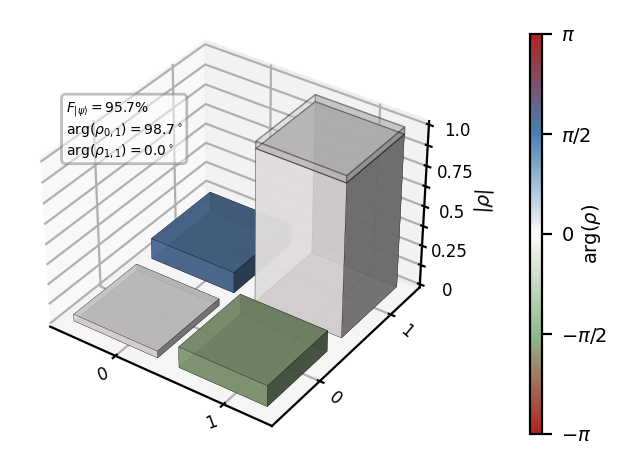

In [285]:
R_0 = np.zeros(rho.shape)
R_0[-1,-1] = 1.0

fid_0 = fidelity(rho, R_0)
angle_01 = np.angle(rho[0,1])*180/np.pi
angle_11 = np.angle(rho[1,1])*180/np.pi
angle_text = r'$\mathrm{arg}(\rho_{0,1})=' + fr'{angle_01:.1f}^\circ$' + '\n' + r'$\mathrm{arg}(\rho_{1,1})=' + fr'{angle_11:.1f}^\circ$'
print(fid_0, angle_01, angle_11)

fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.add_subplot(121, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho, ax, rho_id=R_0, fidelity=fid_0, angle_text=angle_text)
fig.savefig(DATA_DIR + exp_name + "_PLOT2.png", format='png', dpi=200)

## Entaglement by msmt


### Readout correction

In [19]:
qubits = [1, 2, 3]
tomo_qubits = [1, 3]
# qubits = [0, 2, 4]
# tomo_qubits = [0, 4]
sim_msmt = False
exp_name = "entanglement_by_msmt_qbs"
exp_name = exp_name + str(qubits) + f"_tom{tomo_qubits}"
# exp_name = exp_name + "_sim-msmt" if sim_msmt else exp_name
print(exp_name)

entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]


In [22]:
shots_dict = {qb: {} for qb in tomo_qubits}
for state in [''.join(s) for s in it.product(['0', '1'], repeat=2)]:
    print(state)
    bitstrings = get_csv_data(f"readout_correction_qbs{tomo_qubits}_state{state}_RAW.csv")
    pprint(bitstrings)
    for qb in shots_dict.keys():
        shots_dict[qb][state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), bitstrings)))
shots_dict

00
array(['00000', '00000', '00000', ..., '00000', '00000', '00000'],
      dtype='<U5')
01
array(['00000', '01000', '01000', ..., '01000', '01000', '01000'],
      dtype='<U5')
10
array(['00010', '00010', '00010', ..., '00010', '00010', '01010'],
      dtype='<U5')
11
array(['01010', '01010', '01010', ..., '01010', '01010', '01010'],
      dtype='<U5')


{1: {'00': array([1, 1, 1, ..., 1, 1, 1]),
  '01': array([1, 1, 1, ..., 1, 1, 1]),
  '10': array([-1, -1, -1, ..., -1, -1, -1]),
  '11': array([-1, -1, -1, ..., -1, -1, -1])},
 3: {'00': array([1, 1, 1, ..., 1, 1, 1]),
  '01': array([ 1, -1, -1, ..., -1, -1, -1]),
  '10': array([ 1,  1,  1, ...,  1,  1, -1]),
  '11': array([-1, -1, -1, ..., -1, -1, -1])}}

In [26]:
(shots_dict[1]['11'] == shots_dict[3]['11']).all()

False

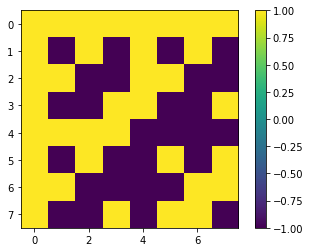

In [99]:
plt.imshow(sp.linalg.pinv(gen_M_matrix(3)))
plt.colorbar()

In [23]:
beta = get_Beta_matrix(shots_dict, 2)
beta

{'IZ': array([ 0.03530884,  0.88919067,  0.01425171, -0.00967407]),
 'ZI': array([1.52282715e-02, 1.12915039e-03, 9.59320068e-01, 7.62939453e-04]),
 'ZZ': array([0.0145874 , 0.00500488, 0.0345459 , 0.85235596])}

In [10]:
beta2 = get_Beta_matrix(shots_dict, 2)
beta2

{'IZ': array([ 0.45265198, -0.43318176, -0.02903748,  0.02610779]),
 'ZI': array([ 0.49346924,  0.00088501, -0.47814941, -0.00088501]),
 'ZZ': array([ 0.2366333 , -0.22567749, -0.23046875,  0.21981812])}

### Tomography data

In [35]:
print(gen_gate_order(2))

['ZZ' 'XZ' 'YZ' 'ZX' 'XX' 'YX' 'ZY' 'XY' 'YY']


In [24]:
# masks_0 = np.empty((len(gen_gate_order(2)), 2**14))
# masks_1 = np.empty((len(gen_gate_order(2)), 2**14))
gate_order = gen_gate_order(2)
masks_0 = [None] * len(gate_order)
masks_1 = [None] * len(gate_order)

tomo_shots_dict = {qb: {} for qb in tomo_qubits}

for i, tomo_state in enumerate(gate_order):
    print(tomo_state)
    filename = exp_name + f"_M{tuple(tomo_state)}" + "_sim-msmt" if sim_msmt else exp_name + f"_M{tuple(tomo_state)}"
    bitstrings = get_csv_data(filename + "_RAW.csv")
    # print(bitstrings)
    if sim_msmt:
        # for simultaneous msmt
        mask_bits = bitstrings
        tomo_bits = bitstrings
    else:
        # for sequential msmt
        mask_bits = bitstrings[0]
        tomo_bits = bitstrings[1]

    # create masks for postselection on state of middle (ancilla) qubit
    masks_0[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 0, 1, np.nan)
    masks_1[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 1, 1, np.nan)

    # create dict for shots by qubit, per tomo_state
    for qb in shots_dict.keys():
        tomo_shots_dict[qb][tomo_state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), tomo_bits)))

tomo_shots_dict

ZZ
XZ
YZ
ZX
XX
YX
ZY
XY
YY


{1: {'ZZ': array([ 1, -1,  1, ...,  1, -1,  1]),
  'XZ': array([ 1, -1, -1, ..., -1,  1, -1]),
  'YZ': array([-1,  1, -1, ...,  1,  1, -1]),
  'ZX': array([1, 1, 1, ..., 1, 1, 1]),
  'XX': array([ 1,  1,  1, ..., -1, -1, -1]),
  'YX': array([ 1, -1, -1, ...,  1, -1,  1]),
  'ZY': array([ 1,  1,  1, ...,  1, -1,  1]),
  'XY': array([-1, -1, -1, ..., -1,  1, -1]),
  'YY': array([ 1,  1,  1, ...,  1,  1, -1])},
 3: {'ZZ': array([ 1, -1,  1, ...,  1,  1,  1]),
  'XZ': array([ 1,  1, -1, ..., -1, -1, -1]),
  'YZ': array([-1,  1, -1, ..., -1,  1,  1]),
  'ZX': array([ 1, -1, -1, ...,  1,  1,  1]),
  'XX': array([-1, -1,  1, ..., -1, -1, -1]),
  'YX': array([ 1, -1,  1, ..., -1,  1,  1]),
  'ZY': array([ 1, -1,  1, ..., -1,  1, -1]),
  'XY': array([ 1, -1, -1, ...,  1,  1,  1]),
  'YY': array([ 1, -1,  1, ..., -1, -1, -1])}}

### Results

In [25]:
Pauli_terms_0, rho_0, P_frac_0 = get_Pauli_expectation_values(beta, gate_order, masks_0,
                                                              Tomo_shots_dig=tomo_shots_dict)
Pauli_terms_1, rho_1, P_frac_1 = get_Pauli_expectation_values(beta, gate_order, masks_1,
                                                              Tomo_shots_dig=tomo_shots_dict)

In [26]:
rho_1

array([[ 0.36556673+0.j        ,  0.02650621-0.0218672j ,
        -0.02411617-0.00299843j,  0.16989142-0.02911069j],
       [ 0.02650621+0.0218672j ,  0.12984404+0.j        ,
        -0.02629398+0.01455778j,  0.01769225+0.01485309j],
       [-0.02411617+0.00299843j, -0.02629398-0.01455778j,
         0.15289951+0.j        , -0.0077886 +0.00291788j],
       [ 0.16989142+0.02911069j,  0.01769225-0.01485309j,
        -0.0077886 -0.00291788j,  0.35168972+0.j        ]])

In [27]:
np.allclose(list(map(np.trace, [rho_1, rho_0])), 1.0)

True

In [29]:
np.abs(rho_1) <= 0.5

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

### Plotting

In [30]:
R_0 = np.zeros(rho_0.shape)
R_0[ 0, 0] = 0.5
R_0[ 0,-1] = 0.5
R_0[-1, 0] = 0.5
R_0[-1,-1] = 0.5

fid_0 = fidelity(rho_0, R_0)
fid_1 = fidelity(rho_1, R_0)
angle_0 = np.angle(rho_0[0,-1])*180/np.pi
angle_1 = np.angle(rho_1[0,-1])*180/np.pi
ps_frac_0 = np.mean(list(P_frac_0.values()))
ps_frac_1 = np.mean(list(P_frac_1.values()))
n_shots = len(tomo_shots_dict[1]['ZZ'])
print(fid_0, fid_1, angle_0, angle_1, ps_frac_0, ps_frac_1)

0.6250201291676586 0.5285196554813263 -26.60860031923401 -9.72313868051619 0.5064888000488281 0.4935111999511719


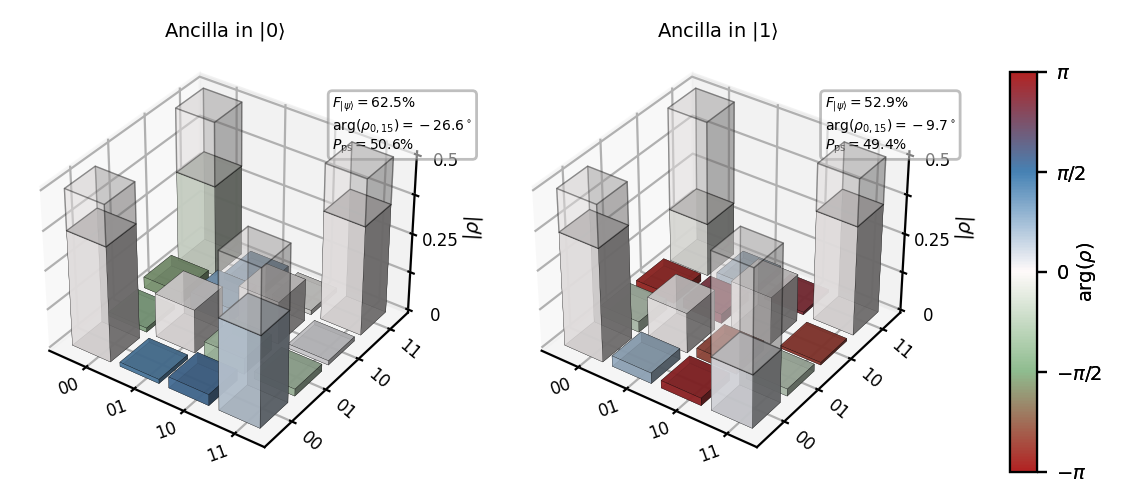

In [31]:
fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=35)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_0, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
# fig.savefig(DATA_DIR + filename, format='png', dpi=200)

0.5706187552933286 0.12420473253336199 -20.312301688053957 0.369108593503929 0.5069007873535156 0.4930992126464844


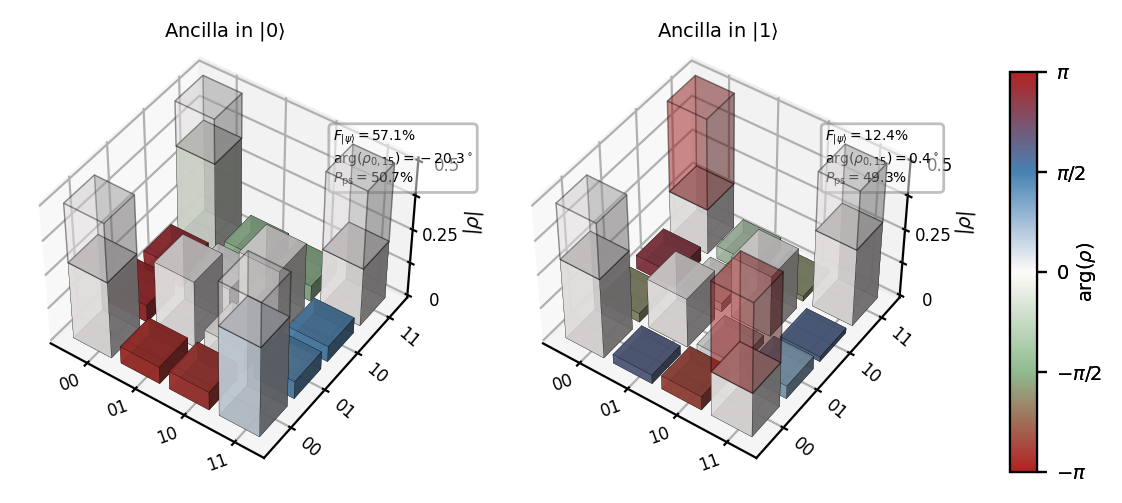

In [70]:
R_0 = np.zeros(rho_0.shape)
R_0[ 0, 0] = 0.5
R_0[ 0,-1] = 0.5
R_0[-1, 0] = 0.5
R_0[-1,-1] = 0.5

R_1 = np.zeros(rho_1.shape)
R_1[ 0, 0] = 0.5
R_1[ 0,-1] = -0.5
R_1[-1, 0] = -0.5
R_1[-1,-1] = 0.5

fid_0 = fidelity(rho_0, R_0)
fid_1 = fidelity(rho_1, R_1)
angle_0 = np.angle(rho_0[0,-1])*180/np.pi
angle_1 = np.angle(rho_1[0,-1])*180/np.pi
ps_frac_0 = np.mean(list(P_frac_0.values()))
ps_frac_1 = np.mean(list(P_frac_1.values()))
n_shots = len(tomo_shots_dict[1]['ZZ'])
print(fid_0, fid_1, angle_0, angle_1, ps_frac_0, ps_frac_1)

fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=45)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=45)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_1, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
# fig.savefig(DATA_DIR + filename, format='png', dpi=200)

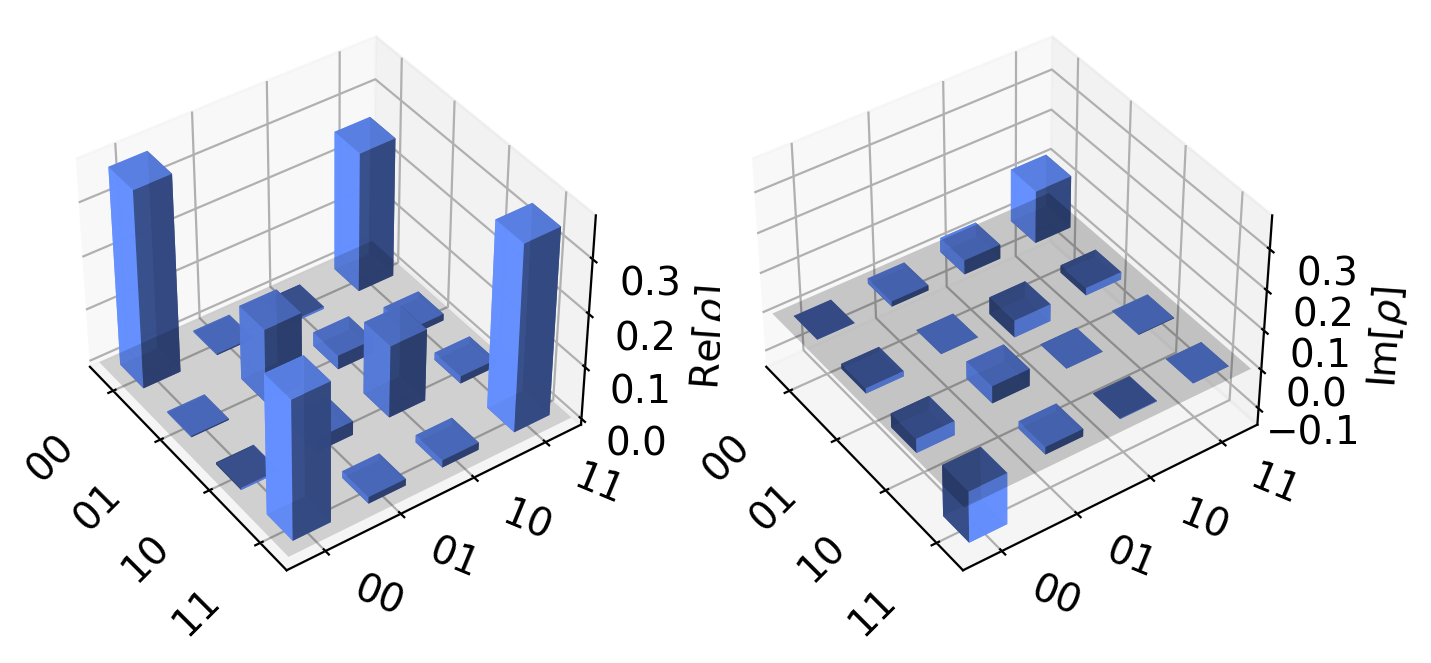

In [32]:
fig = plt.figure(figsize=(8, 8), dpi=200)
ax1 = fig.add_subplot(121, projection='3d', azim=-35, elev=40)
ax2 = fig.add_subplot(122, projection='3d', azim=-35, elev=40)
qvis.plot_state_city(rho_0, alpha=0.9, ax_real=ax1, ax_imag=ax2)
filename = exp_name + "_sim-msmt" + "_PLOT2.png" if sim_msmt else exp_name + "_PLOT2.png"
# fig.savefig(DATA_DIR + filename, format='png', dpi=200)

# Testing

In [75]:
qubits = [1,2,3]
data_hex = np.loadtxt(DATA_DIR + "entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('Z', 'Z')_RAW.csv", comments='#', dtype='<U3', delimiter=',')

# data_bin = np.array(["{0:05b}".format(b) for b in list(map(lambda d: int(d, 16), data_hex.flatten()))]).reshape(data_hex.shape) #int(data_hex, 16))
# np.apply_over_axes(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex, data_hex.shape)
data_bin = np.array(list(map(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex.flatten()))).reshape(data_hex.shape)
# np.take(data_bin[1,0], qubits)
np.fromstring(data_bin[0,0])

/tmp/ipykernel_8820/1087478125.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np.fromstring(data_bin[0,0])


ValueError: string size must be a multiple of element size

In [7]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]"
results = get_json_data(exp_name + "_PROB.json")
results

[{'00000': 0.204345703125,
  '00010': 0.09130859375,
  '00100': 0.19244384765625,
  '00110': 0.09600830078125,
  '01000': 0.05621337890625,
  '01010': 0.14300537109375,
  '01100': 0.06707763671875,
  '01110': 0.14959716796875}]

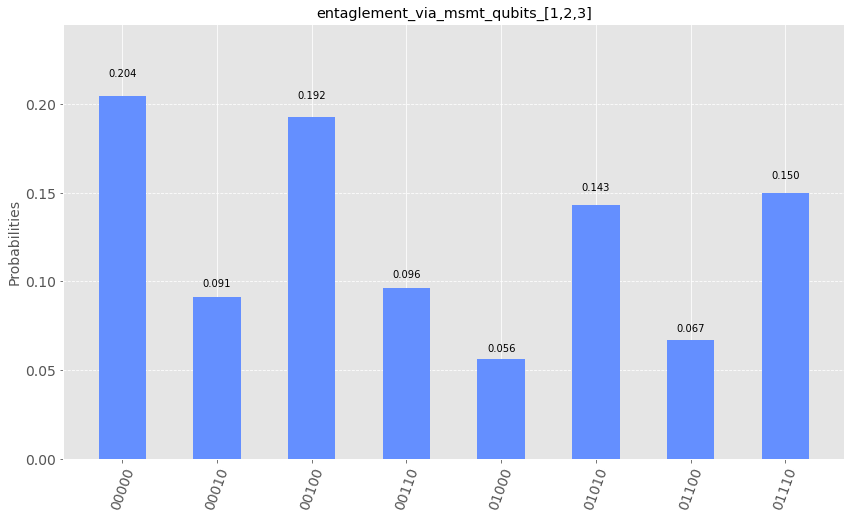

In [16]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))


In [17]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]_with_IDs"
results = get_json_data(exp_name + "_PROB.json")
results


[{'00000': 0.21929931640625,
  '00010': 0.09002685546875,
  '00100': 0.20880126953125,
  '00110': 0.09588623046875,
  '01000': 0.06439208984375,
  '01010': 0.11749267578125,
  '01100': 0.073974609375,
  '01110': 0.130126953125}]

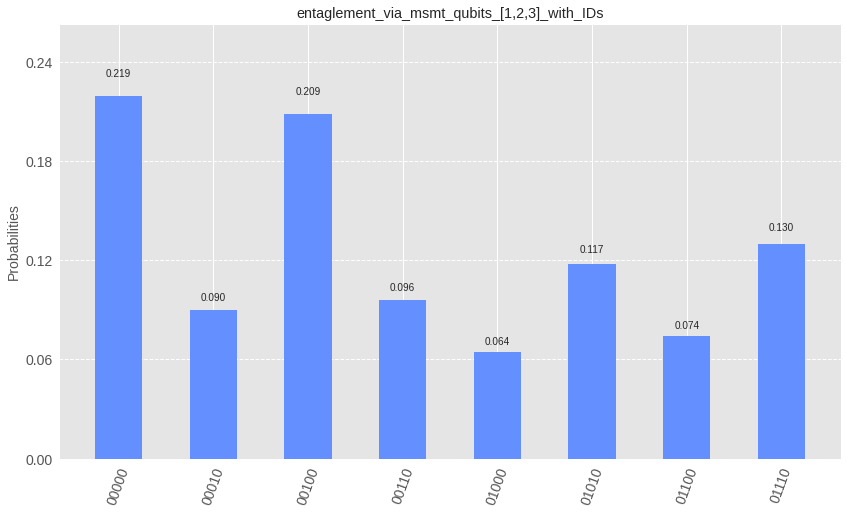

In [26]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))
